# **Preprocessing and Baseline - Edition 2**

## **Introduction**

This notebook demonstrates a time series analysis on financial data. I'm going to use **ARIMA** and **linear regression models** to predict the change in **Net Income Loss** over time.

This notebook details the steps taken to analyze financial data for various tickers using time series methods. In our previous iterations, we focused on basic preprocessing and modeling techniques. This time, we implemented additional preprocessing strategies to handle missing values, scale features, and encode categorical data. Our goal is to build a more robust predictive model for `NetIncomeLoss`.

## **Data Preparation**

- Load the dataset.
- Select the right variables and preprocess the data.

## **Model Building and Evaluation**

- Build an **ARIMA** model.
- Build a **linear regression** model.
- Evaluate both models using appropriate metrics (e.g., **MSE**, **RMSE**, **MAE**).

## **Selecting the Right Variables and Preprocessing the Data**

The dataset contains information about various tickers and their performance across different dates.

As a result, I chose to group the data by tickers.

### **Handling the Timespan**

Each ticker has data reported daily, but for analysis, the data will be aggregated to a quarterly frequency. Each quarter will be treated as a unique time point to better align with financial reporting periods.

### **Selecting the Right Variables**

#### **Core Financial Features:**
- **Revenues**: Indicates the total income generated by the company.
- **GrossProfit**: Useful for understanding the company's profitability before accounting for operating expenses.
- **ProfitLoss**: Represents the net profit or loss for the period, which could be strongly related to `NetIncomeLoss`.

#### **Macro-Economic Features:**
- **GDP**: Gross Domestic Product, indicating the economic performance of the country.
- **Interest Rate**: The prevailing interest rate, which can impact company financing and profitability.
- **Unemployment Rate**: Reflects the economic environment affecting consumer spending.
- **Median CPI**: The Consumer Price Index, indicating inflation levels that can impact financial performance.

#### **Target Variable:**
- **NetIncomeLoss**: Remains a strong candidate for the target variable, representing the net outcome after all expenses.

### **Potential Additional Features:**
Below is a list of additional features that were considered for the baseline model:
- **Revenues**: Included as it directly impacts profitability.
- **GrossProfit**: Included to see how profitability before operating expenses impacts the net outcome.
- **ProfitLoss**: While it might be highly correlated with `NetIncomeLoss`, including it provides additional context and insights into financial performance.

## **Baseline**

/home/dda/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/dda/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/dda/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


ARIMA Log-Likelihood: -3298.9078906624327
Linear Regression MSE: 137369437339164.62
Linear Regression MAE: 5500506.837325442


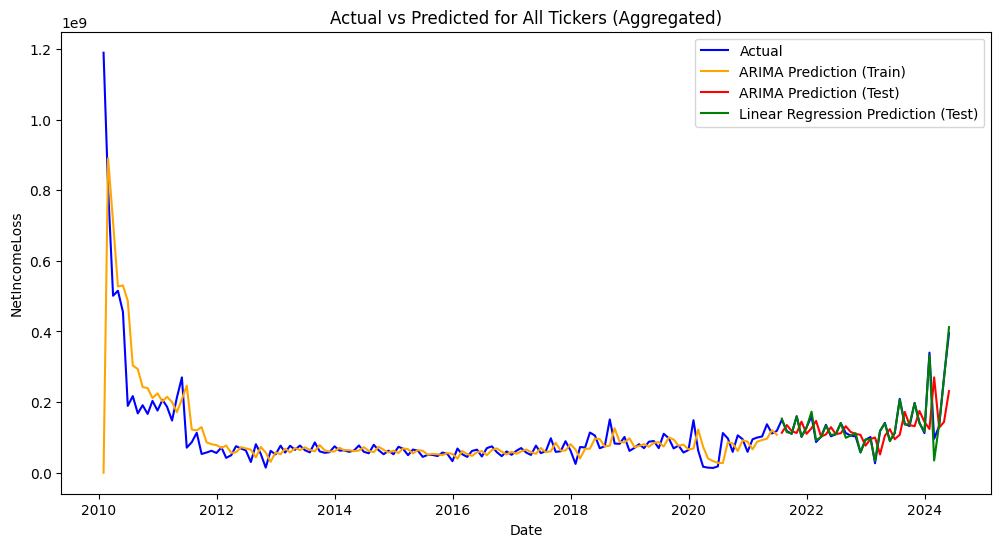

In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load the dataset from a CSV file
file_path = r'df_financials_fred.csv'
df = pd.read_csv(file_path)

# Ensure the 'date' is in the datetime format
df['date'] = pd.to_datetime(df['date'])

# Sorting the dataframe by ticker and date
df = df.sort_values(by=['cik', 'date'])

# Feature Selection
features = ['Revenues', 'GrossProfit', 'ProfitLoss']  # Keep core features
target = 'NetIncomeLoss'

# Prepare data for modeling
df = df[['cik', 'date'] + features + [target]]

# Grouping the data by date and aggregating across all tickers
df_grouped = df.groupby('date').mean()

# Handle missing data
df_grouped.fillna(method='ffill', inplace=True)  # Forward fill to handle any missing data

# Apply ARIMA on the aggregated data
arima_model = ARIMA(df_grouped[target], order=(1, 1, 1))  # Simplified model
arima_result = arima_model.fit()

# ARIMA predictions
arima_pred = arima_result.predict(start=0, end=len(df_grouped) - 1)

# Prepare data for Linear Regression
X = df_grouped[features]
y = df_grouped[target]

# Train and test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Apply Linear Regression
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
y_pred = lin_reg_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print results
print(f"ARIMA Log-Likelihood: {arima_result.llf}")
print(f"Linear Regression MSE: {mse}")
print(f"Linear Regression MAE: {mae}")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(df_grouped.index, df_grouped[target], label='Actual', color='blue')
plt.plot(df_grouped.index[:train_size], arima_pred[:train_size], label='ARIMA Prediction (Train)', color='orange')
plt.plot(df_grouped.index[train_size:], arima_pred[train_size:], label='ARIMA Prediction (Test)', color='red')
plt.plot(df_grouped.index[train_size:], y_pred, label='Linear Regression Prediction (Test)', color='green')
plt.title('Actual vs Predicted for All Tickers (Aggregated)')
plt.xlabel('Date')
plt.ylabel(target)
plt.legend()
plt.show()


## **Cross-Validation**

In [28]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Define the number of splits for cross-validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize lists to store cross-validation results
arima_mse_scores = []
arima_mae_scores = []
lin_reg_mse_scores = []
lin_reg_mae_scores = []

# Apply cross-validation
for train_index, test_index in tscv.split(df_grouped):
    # Split the data
    train, test = df_grouped.iloc[train_index], df_grouped.iloc[test_index]

    # ARIMA Model
    arima_model = ARIMA(train[target], order=(1, 1, 1))
    arima_result = arima_model.fit()
    arima_pred = arima_result.predict(start=test.index[0], end=test.index[-1])

    # Calculate ARIMA metrics
    arima_mse = mean_squared_error(test[target], arima_pred)
    arima_mae = mean_absolute_error(test[target], arima_pred)

    arima_mse_scores.append(arima_mse)
    arima_mae_scores.append(arima_mae)

    # Linear Regression Model
    X_train, X_test = train[features], test[features]
    y_train, y_test = train[target], test[target]

    lin_reg_model = LinearRegression()
    lin_reg_model.fit(X_train, y_train)
    y_pred = lin_reg_model.predict(X_test)

    # Calculate Linear Regression metrics
    lin_reg_mse = mean_squared_error(y_test, y_pred)
    lin_reg_mae = mean_absolute_error(y_test, y_pred)

    lin_reg_mse_scores.append(lin_reg_mse)
    lin_reg_mae_scores.append(lin_reg_mae)

# Output the cross-validation results
print("ARIMA Cross-Validation Results:")
print(f"Average MSE: {np.mean(arima_mse_scores)}")
print(f"Average MAE: {np.mean(arima_mae_scores)}")

print("\nLinear Regression Cross-Validation Results:")
print(f"Average MSE: {np.mean(lin_reg_mse_scores)}")
print(f"Average MAE: {np.mean(lin_reg_mae_scores)}")

/home/dda/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/dda/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/dda/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/dda/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/dda/.pyenv/versions/lewagon/lib/python3.10/site-

ARIMA Cross-Validation Results:
Average MSE: 1838065788123944.0
Average MAE: 25786260.916274022

Linear Regression Cross-Validation Results:
Average MSE: 53247072101998.45
Average MAE: 3558214.5380284786


/home/dda/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/dda/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/dda/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/dda/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/dda/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471